In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)
dataframes = {sheet: xls.parse(sheet) for sheet in xls.sheet_names}

In [19]:
print("Available Tables:", xls.sheet_names)

Available Tables: ['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']


In [21]:
for sheet, df in dataframes.items():
    print(f"\nTable: {sheet}")
    print(df.head())


Table: customers
   customer_id  join_date  city_id  gender_id
0            1 2022-01-08        7          1
1            2 2023-05-02       20          2
2            3 2023-05-14       15          1
3            4 2022-11-25       11          2
4            5 2023-04-26        8          1

Table: genders
   gender_id gender_name
0          1        Male
1          2      Female

Table: cities
   city_id         city_name
0        1             Cairo
1        2        Alexandria
2        3              Giza
3        4  Shubra El-Kheima
4        5         Port Said

Table: transactions
   transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12        

In [24]:
for sheet, df in dataframes.items():
    print(f"\nMissing Values in {sheet}:")
    print(df.isnull().sum())


Missing Values in customers:
customer_id    0
join_date      0
city_id        0
gender_id      0
dtype: int64

Missing Values in genders:
gender_id      0
gender_name    0
dtype: int64

Missing Values in cities:
city_id      0
city_name    0
dtype: int64

Missing Values in transactions:
transaction_id           0
customer_id              0
transaction_date         0
transaction_status       0
coupon_name              0
burn_date             2484
branch_id                0
dtype: int64

Missing Values in branches:
branch_id      0
merchant_id    0
dtype: int64

Missing Values in merchants:
merchant_id      0
merchant_name    0
dtype: int64


In [26]:
dataframes["customers"]["join_date"] = pd.to_datetime(dataframes["customers"]["join_date"])
dataframes["transactions"]["transaction_date"] = pd.to_datetime(dataframes["transactions"]["transaction_date"])
dataframes["transactions"]["burn_date"] = pd.to_datetime(dataframes["transactions"]["burn_date"])

In [28]:
customers_df = dataframes["customers"].merge(dataframes["genders"], on="gender_id", how="left")
customers_df = customers_df.merge(dataframes["cities"], on="city_id", how="left")
transactions_df = dataframes["transactions"].merge(dataframes["branches"], on="branch_id", how="left")
transactions_df = transactions_df.merge(dataframes["merchants"], on="merchant_id", how="left")
transactions_df = transactions_df.merge(customers_df, on="customer_id", how="left")

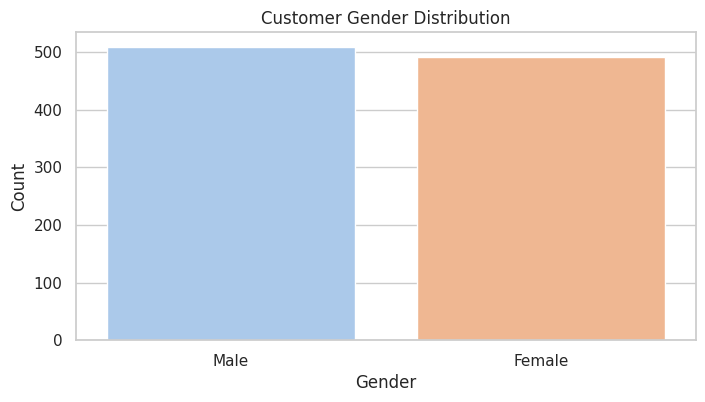

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.countplot(x="gender_name", data=customers_df, palette="pastel", hue="gender_name", legend=False)
plt.title("Customer Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

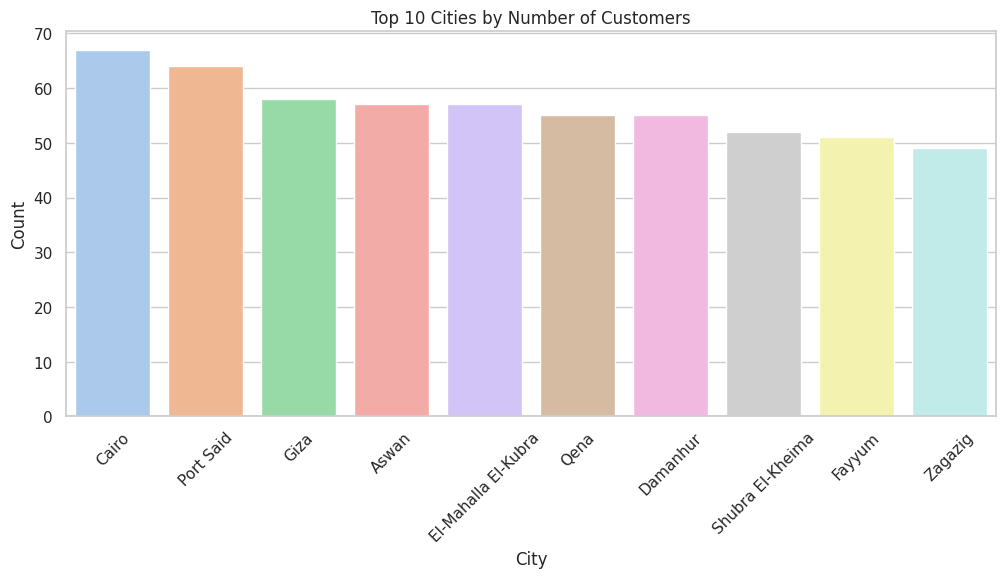

In [36]:
plt.figure(figsize=(12, 5))
top_cities = customers_df["city_name"].value_counts().nlargest(10)
sns.barplot(x=top_cities.index, y=top_cities.values, palette="pastel", hue=top_cities.index, legend=False)
plt.title("Top 10 Cities by Number of Customers")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x500 with 0 Axes>

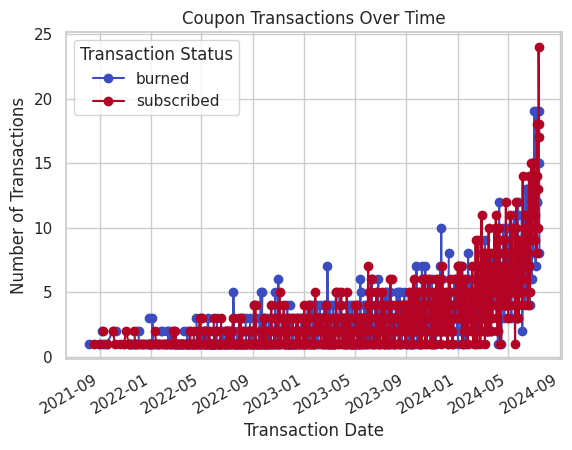

In [42]:
coupon_trends = transactions_df.groupby(["transaction_date", "transaction_status"]).size().unstack()
plt.figure(figsize=(12, 5))
coupon_trends.plot(kind="line", marker="o", colormap="coolwarm")
plt.title("Coupon Transactions Over Time")
plt.xlabel("Transaction Date")
plt.ylabel("Number of Transactions")
plt.legend(title="Transaction Status")
plt.grid(True)
plt.show()

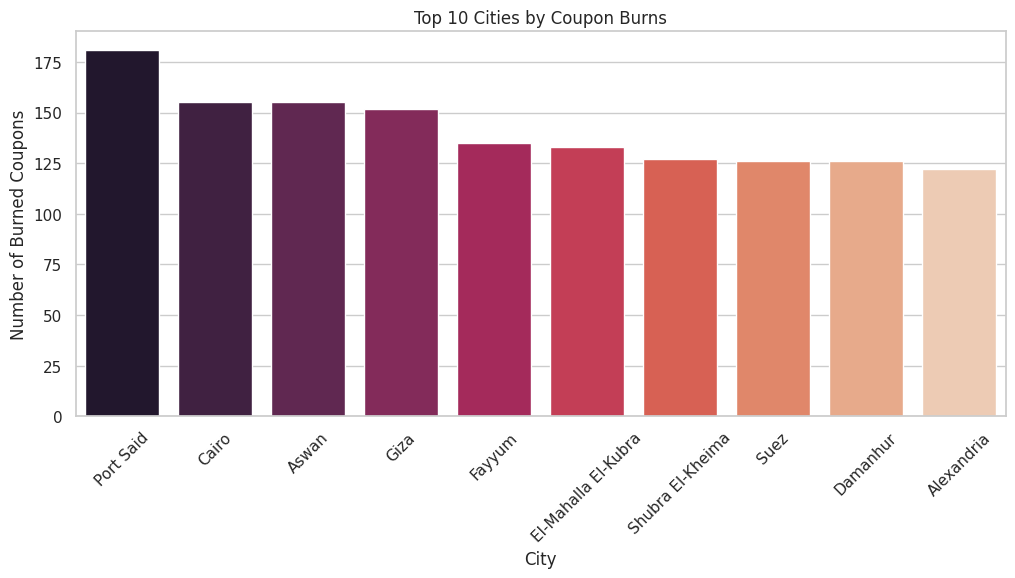

In [46]:
burned_coupons = transactions_df[transactions_df["transaction_status"] == "burned"]
plt.figure(figsize=(12, 5))
top_burn_cities = burned_coupons["city_name"].value_counts().nlargest(10)
sns.barplot(x=top_burn_cities.index, y=top_burn_cities.values, palette="rocket", hue=top_burn_cities.index, legend=False)
plt.title("Top 10 Cities by Coupon Burns")
plt.xlabel("City")
plt.ylabel("Number of Burned Coupons")
plt.xticks(rotation=45)
plt.show()

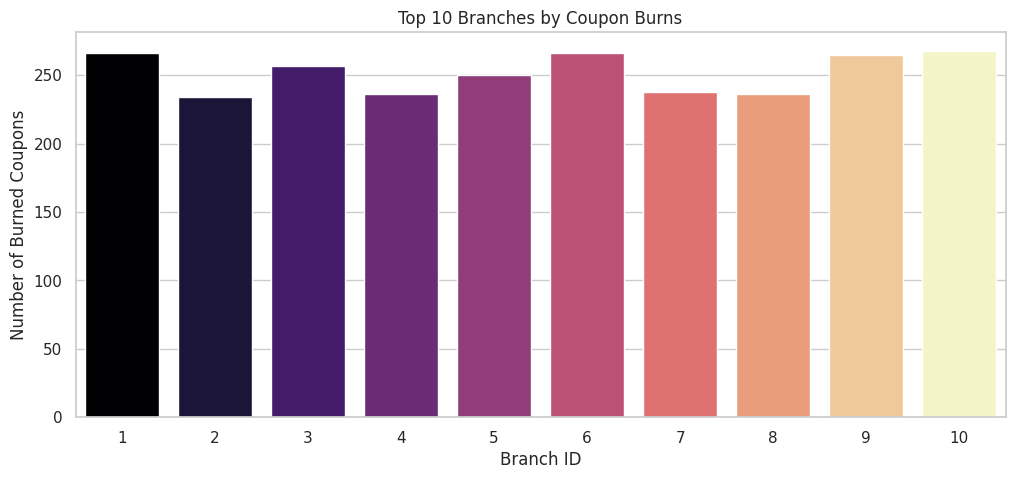

In [49]:
plt.figure(figsize=(12, 5))
top_burn_branches = burned_coupons["branch_id"].value_counts().nlargest(10)
sns.barplot(x=top_burn_branches.index, y=top_burn_branches.values, palette="magma", hue=top_burn_branches.index, legend=False)
plt.title("Top 10 Branches by Coupon Burns")
plt.xlabel("Branch ID")
plt.ylabel("Number of Burned Coupons")
plt.show()

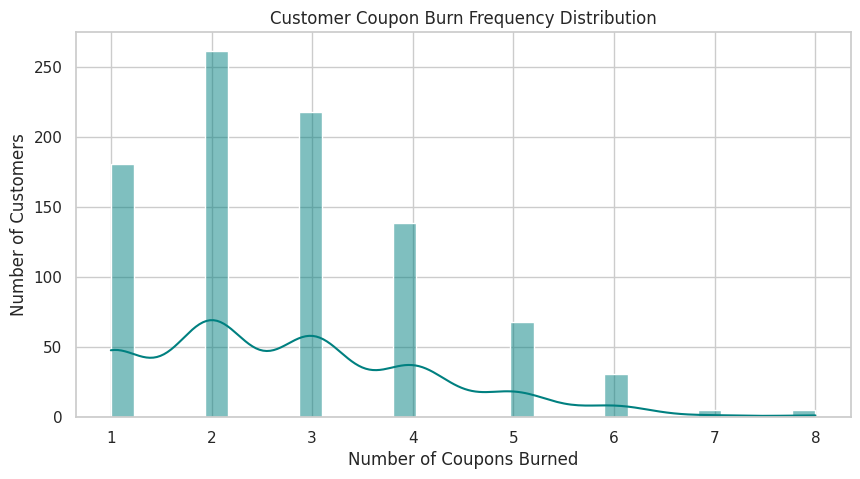

In [55]:
burn_frequency = burned_coupons["customer_id"].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(burn_frequency, bins=30, kde=True, color="teal")
plt.title("Customer Coupon Burn Frequency Distribution")
plt.xlabel("Number of Coupons Burned")
plt.ylabel("Number of Customers")
plt.show()

In [70]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

coupon_usage = transactions_df.groupby('customer_id')['transaction_id'].count().reset_index()
coupon_usage.rename(columns={'transaction_id': 'coupon_usage_frequency'}, inplace=True)
if 'coupon_usage_frequency' not in customers_df.columns:
    customers_df = customers_df.merge(coupon_usage, on='customer_id', how='left')
else:
    customers_df['coupon_usage_frequency'] = customers_df['customer_id'].map(coupon_usage.set_index('customer_id')['coupon_usage_frequency'])
features = customers_df[['customer_id', 'gender_id', 'city_id', 'coupon_usage_frequency']]
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_imputed)
kmeans = KMeans(n_clusters=5, random_state=42)
customers_df['segment'] = kmeans.fit_predict(scaled_features)

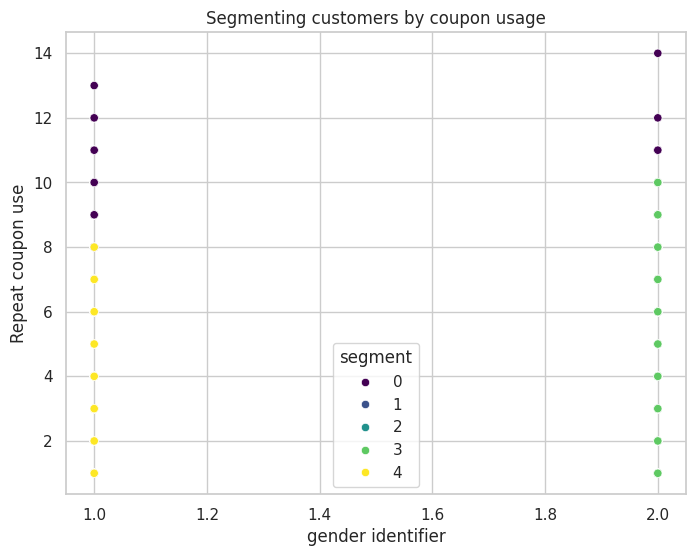

In [76]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customers_df['gender_id'], y=customers_df['coupon_usage_frequency'], hue=customers_df['segment'], palette='viridis')
plt.title('Segmenting customers by coupon usage')
plt.xlabel('gender identifier')
plt.ylabel('Repeat coupon use')
plt.show()

In [78]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(scaled_features, customers_df['segment'])
print(f'درجة سيلويت: {sil_score}')

درجة سيلويت: 0.2456822566025385
